In [43]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [44]:
from fastai.vision import *
from fastai.metrics import error_rate
import wandb
import os
from wandb.fastai import WandbCallback

In [13]:
os.environ['TORCH_HOME'] = '../torch-zoo'

In [54]:
wandb.init(project='plant-seedlings', name='FastAI Resnet-152 finetune 2nd')

W&B Run: https://app.wandb.ai/basedrhys/plant-seedlings/runs/kqrmt3mp

In [14]:
bs = 16

In [15]:
data = ImageDataBunch.from_folder(path='data/train',
                                 ds_tfms=get_transforms(flip_vert=True), 
                                  size=224,
                                  valid_pct=0.15,
                                  bs=bs)

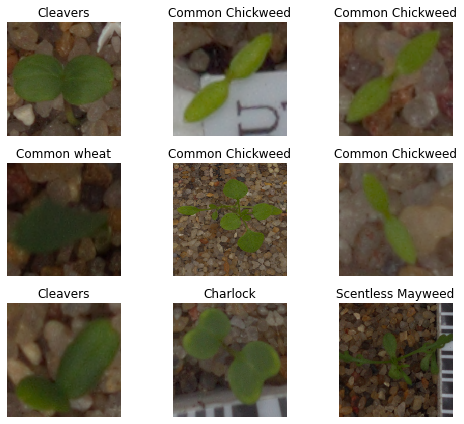

In [16]:
data.show_batch(rows=3, figsize=(7,6))

In [8]:
learn = cnn_learner(data, models.resnet152, metrics=[error_rate], callback_fns=WandbCallback)
learn.path = Path('.')

In [9]:
learn.fit_one_cycle(30)

epoch,train_loss,valid_loss,error_rate,time
0,1.415130,0.782059,0.258427,02:59
1,0.962083,0.562043,0.176966,02:40
2,0.708989,0.422568,0.155899,02:40
3,0.616282,0.321463,0.112360,02:41
4,0.470010,0.257946,0.101124,02:42
5,0.417554,0.450105,0.106742,02:41
6,0.362873,0.264874,0.098315,02:40
7,0.411128,0.297336,0.091292,02:41
8,0.331816,0.230077,0.074438,02:41
9,0.256443,0.302885,0.061798,02:41


Better model found at epoch 0 with valid_loss value: 0.7820586562156677.
Better model found at epoch 1 with valid_loss value: 0.5620434880256653.
Better model found at epoch 2 with valid_loss value: 0.4225683808326721.
Better model found at epoch 3 with valid_loss value: 0.321463406085968.
Better model found at epoch 4 with valid_loss value: 0.257945716381073.
Better model found at epoch 8 with valid_loss value: 0.2300766557455063.
Better model found at epoch 11 with valid_loss value: 0.1909719705581665.
Better model found at epoch 12 with valid_loss value: 0.169171541929245.
Better model found at epoch 13 with valid_loss value: 0.1419699341058731.
Better model found at epoch 18 with valid_loss value: 0.12959501147270203.
Better model found at epoch 21 with valid_loss value: 0.12791426479816437.
Better model found at epoch 22 with valid_loss value: 0.10599693655967712.
Better model found at epoch 26 with valid_loss value: 0.10266709327697754.
Loaded best saved model from E:\Rhys\Docume

In [10]:
learn.save('rn152_30')

wandb: ERROR Error uploading "bestmodel.pth": CommError, <Response [400]>


In [ ]:
learn.load('rn152_30')

In [10]:
learn.fit_one_cycle(15)

epoch,train_loss,valid_loss,error_rate,time
0,0.071595,0.035454,0.009831,03:13
1,0.115720,0.042223,0.015449,02:45
2,0.102055,0.047122,0.015449,02:42
3,0.135492,0.070066,0.022472,02:43
4,0.130164,0.081986,0.021067,02:43
5,0.137000,0.110555,0.028090,02:43
6,0.141234,0.081216,0.021067,02:43
7,0.109741,0.081887,0.029494,02:43
8,0.099961,0.138394,0.029494,02:43
9,0.102495,0.078423,0.021067,02:43


Better model found at epoch 0 with valid_loss value: 0.03545351326465607.
Loaded best saved model from E:\Rhys\Documents\Github\kaggle-competitions\plant-seedlings\wandb\run-20200217_043753-9zoyi0x5\bestmodel.pth


wandb: ERROR Error uploading "bestmodel.pth": CommError, <Response [400]>


In [18]:
learn.save('rn152_45')

In [55]:
learn.load('e45_0.147')

Learner(data=ImageDataBunch;

Train: LabelList (4038 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Black-grass,Black-grass,Black-grass,Black-grass,Black-grass
Path: data\train;

Valid: LabelList (712 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Loose Silky-bent,Scentless Mayweed,Black-grass,Loose Silky-bent,Common wheat
Path: data\train;

Test: LabelList (794 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: data\train, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, d

In [56]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,time
0,0.100912,0.022714,02:41
1,0.078361,0.030314,02:40
2,0.128721,0.069784,02:41
3,0.127890,0.054201,02:41
4,0.130920,0.063072,02:40
5,0.105467,0.066494,02:39
6,0.107515,0.081793,02:40
7,0.079362,0.036622,02:40
8,0.087469,0.067580,02:40
9,0.061578,0.059781,02:44


In [57]:
learn.save('e55_0.060')

# Running Model On Test Data

In [ ]:
learn = cnn_learner(data, models.resnet152)
learn.path = Path('.')
learn.load('bestmodel1')

In [20]:
tta_params = {'beta':0.12, 'scale':1.0}
sample_df = pd.read_csv('data/sample_submission.csv')
sample_df.head()

,file,species
0,0021e90e4.png,Sugar beet
1,003d61042.png,Sugar beet
2,007b3da8b.png,Sugar beet
3,0086a6340.png,Sugar beet
4,00c47e980.png,Sugar beet


In [21]:
learn.data.add_test(ImageList.from_df(
    sample_df,
    Path('data/test')
))

In [22]:
preds, y = learn.TTA(ds_type=DatasetType.Test, **tta_params)

In [23]:
os.makedirs('submissions', exist_ok=True)

In [24]:
classes = ['Black-grass',
'Charlock',
'Cleavers',
'Common Chickweed',
'Common wheat',
'Fat Hen',
'Loose Silky-bent',
'Maize',
'Scentless Mayweed',
'Shepherds Purse',
'Small-flowered Cranesbill',
'Sugar beet']

In [25]:
classes = [classes[i] for i in preds.argmax(1)]

In [26]:
sample_df.species = classes

In [27]:
sample_df.head()

,file,species
0,0021e90e4.png,Small-flowered Cranesbill
1,003d61042.png,Fat Hen
2,007b3da8b.png,Sugar beet
3,0086a6340.png,Common Chickweed
4,00c47e980.png,Sugar beet


In [29]:
sample_df.to_csv('submissions/e26_0.103.csv', index=False)

In [48]:
classes = ['Black-grass',
'Charlock',
'Cleavers',
'Common Chickweed',
'Common wheat',
'Fat Hen',
'Loose Silky-bent',
'Maize',
'Scentless Mayweed',
'Shepherds Purse',
'Small-flowered Cranesbill',
'Sugar beet']

# Run testing on a bunch of models

In [49]:
def run_test(model_name):
    print("Running", model_name)
    learn = cnn_learner(data, models.resnet152)
    learn.path = Path('.')
    learn.load(model_name)
    
    tta_params = {'beta':0.12, 'scale':1.0}
    sample_df = pd.read_csv('data/sample_submission.csv')
    
    learn.data.add_test(ImageList.from_df(
        sample_df,
        Path('data/test')
    ))
    
    preds, y = learn.TTA(ds_type=DatasetType.Test, **tta_params)
    
    os.makedirs('submissions', exist_ok=True)
    
    submission_classes = [classes[i] for i in preds.argmax(1)]
    sample_df.species = submission_classes
    sample_df.to_csv('submissions/{}.csv'.format(model_name), index=False)

In [46]:
trained_models = [x.strip('.pth') for x  in os.listdir('models') if x.endswith('.pth')]
trained_models

['e26_0.103', 'e30_0.108', 'e31_0.035', 'e45_0.147']

In [50]:
[run_test(x) for x in trained_models]

Running e26_0.103


Running e30_0.108


Running e31_0.035


Running e45_0.147


[None, None, None, None]

In [58]:
run_test('e55_0.060')

Running e55_0.060
